In [1]:
import sympy as sp
import numpy as np
from scipy import optimize
import sys

sys.path.append("..")

from cge_modeling.sympy_tools import info_to_symbols, enumerate_indexbase, sub_all_eqs
from cge_modeling.production_functions import leontief, cobb_douglass
from cge_modeling.cge import (
    compile_cge_to_numba,
    expand_compact_system,
    recursive_solve_symbolic,
    numba_linearize_cge_func,
)
from cge_modeling.numba_tools import euler_approx, numba_lambdify

import pandas as pd

In [2]:
def symbol(name, *sectors):
    if sectors == ():
        return sp.Symbol(name, **default_assumptions)
    suffix = "_" + "_".join(sectors)
    return sp.Symbol(f"{name}{suffix}", **default_assumptions)


def symbols(name, value, sectors):
    return {symbol(name, sector): value for sector in sectors}


def remove_string_keys(d):
    d_copy = d.copy()
    for k in d:
        if isinstance(k, str):
            del d_copy[k]
    return d_copy

# Data

In [3]:
df = pd.read_csv("data/lesson_4_sam.csv", index_col=[0, 1], header=[0, 1]).applymap(float).fillna(0)
assert np.allclose(df.sum(axis=0), df.sum(axis=1))
df

Factor         Institution                  \
                                   Labor Capital   Household   Firms    Govt   
Factor      Labor                    0.0     0.0         0.0     0.0     0.0   
            Capital                  0.0     0.0         0.0     0.0     0.0   
Institution Household             7200.0     0.0         0.0  2800.0     0.0   
            Firms                    0.0  2800.0         0.0     0.0     0.0   
            Govt                     0.0     0.0      3000.0     0.0     0.0   
Production  Agriculture              0.0     0.0      1700.0     0.0   400.0   
            Industry                 0.0     0.0      1200.0     0.0  1500.0   
            Services                 0.0     0.0      3400.0     0.0  2300.0   
Activities  Agriculture              0.0     0.0         0.0     0.0     0.0   
            Industry                 0.0     0.0         0.0     0.0     0.0   
            Services                 0.0     0.0         0.0     0.0     0.0   
Other       Capital Accumulation     0.0     0.0       700.0     0.0   250.0   

                                  Production                    Activities  \
                                 Agriculture Industry Services Agriculture   
Factor      Labor                        0.0      0.0      0.0      1300.0   
            Capital                      0.0      0.0      0.0       200.0   
Institution Household                    0.0      0.0      0.0         0.0   
            Firms                        0.0      0.0      0.0         0.0   
            Govt                       150.0   1020.0    280.0         0.0   
Production  Agriculture                  0.0      0.0      0.0      1000.0   
            Industry                     0.0      0.0      0.0      2010.0   
            Services                     0.0      0.0      0.0       490.0   
Activities  Agriculture               5000.0      0.0      0.0         0.0   
            Industry                     0.0  11000.0      0.0         0.0   
            Services                     0.0      0.0   9500.0         0.0   
Other       Capital Accumulation         0.0      0.0      0.0         0.0   

                                                                  Other  
                                 Industry Services Capital Accumulation  
Factor      Labor                  1900.0   4000.0                  0.0  
            Capital                2100.0    500.0                  0.0  
Institution Household                 0.0      0.0                  0.0  
            Firms                     0.0      0.0                  0.0  
            Govt                      0.0      0.0                  0.0  
Production  Agriculture            1000.0   1000.0                 50.0  
            Industry               3510.0   3000.0                800.0  
            Services               2490.0   1000.0                100.0  
Activities  Agriculture               0.0      0.0                  0.0  
            Industry                  0.0      0.0                  0.0  
            Services                  0.0      0.0                  0.0  
Other       Capital Accumulation      0.0      0.0                  0.0

# Setup

In [4]:
default_assumptions = {"real": True}
sectors = ["Ag", "Ind", "Serv"]
i, j = [sp.Idx(name) for name in list("ij")]
index_dict = {i: sectors, j: sectors}

In [142]:
var_info = [
    ("Y", (i,)),
    ("VA", (i,)),
    ("IC", (i,)),
    ("CIJ", (i, j)),
    ("C", (i,)),
    ("C_G", (i,)),
    ("Ld", (i,)),
    ("Kd", (i,)),
    ("Id", (i,)),
    ("P", (i,)),
    ("P_VA", (i,)),
    ("P_IC", (i,)),
    ("P_Y", (i,)),
    ("U", ()),
    ("r", ()),
    ("w", ()),
    ("Is", ()),
    ("income", ()),
    ("net_income", ()),
    # ('sales_tax', (i, )),
    ("income_tax", ()),
    ("G", ()),
    ("G_savings", ()),
    ("hh_savings", ()),
    ("walras_resid", ()),
]

variables = info_to_symbols(var_info, default_assumptions)
(
    Y,
    VA,
    IC,
    CIJ,
    C,
    C_G,
    Ld,
    Kd,
    Id,
    P,
    P_VA,
    P_IC,
    P_Y,
    U,
    r,
    w,
    Is,
    income,
    net_income,
    income_tax,
    G,
    G_savings,
    hh_savings,
    walras_resid,
) = variables

In [143]:
param_info = [
    ("psi_VA", (i,)),
    ("psi_IC", (i,)),
    ("psi_CIJ", (i, j)),
    ("alpha", (i,)),
    ("alpha_k", (i,)),
    ("alpha_G", (i,)),
    ("tau", (i,)),
    ("gamma", (i,)),
    ("A", (i,)),
    ("mps", ()),
    ("Ls", ()),
    ("Ks", ()),
    ("tau_income", ()),
    ("P_Ag_bar", ()),
    ("G_savings_bar", ()),
]

parameters = info_to_symbols(param_info, default_assumptions)
(
    psi_VA,
    psi_IC,
    psi_CIJ,
    alpha,
    alpha_k,
    alpha_G,
    tau,
    gamma,
    A,
    mps,
    Ls,
    Ks,
    tau_income,
    P_Ag_bar,
    G_savings_bar,
) = parameters

In [144]:
final_goods_block = leontief(Y, P_Y, [IC, VA], [P_IC, P_VA], [psi_IC, psi_VA])
value_add_block = cobb_douglass(VA, P_VA, A, [Kd, Ld], [r, w], [alpha])

# Need to change how indexing is done in the intermediate block, because the model flips the indices for these equations
# So need to make some dummy variables
inter_names = ["P_IC", "IC", "P", "CIJ", "psi_CIJ", "IC"]
P_IC2, IC2, P2, CIJ2, psi_CIJ2, IC2 = [
    sp.IndexedBase(name, **default_assumptions) for name in inter_names
]

intermediate_goods_block = [
    P_IC2[j] * IC2[j] - sp.Sum(P2[i] * CIJ2[i, j], (i, 0, 2)).doit(),
    CIJ2[i, j] - psi_CIJ2[i, j] * IC2[j],
]

other_equations = [
    # Price level
    P - P_Y * (1 + tau),
    # Income block
    income - w * Ls - r * Ks,
    net_income - (1 - tau_income) * income,
    hh_savings - mps * net_income,
    # Household demand block
    U - sp.Product(C**gamma, (i, 0, 2)).doit(),
    gamma * (1 - mps) * net_income - P * C,
    # Firm demand for investment capital
    P * Id - alpha_k * Is,
    # Government block
    tau_income * income + sp.Sum(tau * P_Y * Y, (i, 0, 2)).doit() - G - G_savings,
    P * C_G - alpha_G * G,
    G_savings - G_savings_bar,
    # # Definiton of tax rates
    # tau - sales_tax / (Y - sales_tax),
    income_tax - (income - net_income),
    # Market Equlibrium
    Ls - sp.Sum(Ld, (i, 0, 2)).doit(),
    Ks - sp.Sum(Kd, (i, 0, 2)).doit(),
    C + sp.Sum(CIJ, (j, 0, 2)).doit() + C_G + Id - Y,
    hh_savings + G_savings - Is - walras_resid,
    # Numeraire
    P.subs({i: 0}) - P_Ag_bar,
]

equations = final_goods_block + value_add_block + intermediate_goods_block + other_equations

In [145]:
full_system, named_variables, named_params = expand_compact_system(
    compact_equations=equations,
    compact_variables=variables,
    compact_params=parameters,
    index_dict=index_dict,
)

# Calibration

In [146]:
short_to_long = {"Ag": "Agriculture", "Ind": "Industry", "Serv": "Services"}

# Normalize prices
initial_values = {w: 1, r: 1, walras_resid: 0}
initial_values.update(symbols("P_VA", 1, sectors))
initial_values.update(symbols("P_IC", 1, sectors))
initial_values.update(symbols("P_Y", 1, sectors))

# Enter data from SAM
initial_values[income_tax] = df.loc[("Institution", "Govt"), ("Institution", "Household")]
initial_values[hh_savings] = df.loc[("Other", "Capital Accumulation"), ("Institution", "Household")]
initial_values[G_savings] = df.loc[("Other", "Capital Accumulation"), ("Institution", "Govt")]

# Aggregates
initial_values[Ls] = df.loc[("Institution", "Household"), ("Factor", "Labor")]
initial_values[Ks] = df.loc[("Institution", "Firms"), ("Factor", "Capital")]

initial_values[income] = (
    initial_values[w] * initial_values[Ls] + initial_values[r] * initial_values[Ks]
)
initial_values[tau_income] = initial_values[income_tax] / initial_values[income]
initial_values[net_income] = (1 - initial_values[tau_income]) * initial_values[income]

for sector in sectors:
    long_sector = short_to_long[sector]
    initial_values[symbol("Ld", sector)] = (
        df.loc[("Factor", "Labor"), ("Activities", long_sector)] / initial_values[w]
    )
    initial_values[symbol("Kd", sector)] = (
        df.loc[("Factor", "Capital"), ("Activities", long_sector)] / initial_values[r]
    )
    initial_values[symbol("C_G", sector)] = df.loc[
        ("Production", long_sector), ("Institution", "Govt")
    ]
    initial_values[symbol("sales_tax", sector)] = df.loc[
        ("Institution", "Govt"), ("Production", long_sector)
    ]
    initial_values[symbol("C", sector)] = df.loc[
        ("Production", long_sector), ("Institution", "Household")
    ]
    initial_values[symbol("Y", sector)] = df.sum(axis=0).loc[("Production", long_sector)]
    initial_values[symbol("Id", sector)] = df.loc[
        ("Production", long_sector), ("Other", "Capital Accumulation")
    ]

    # Work out the tax rate from tax reciepts
    tax_rate = symbol("tau", sector)
    T_sec = initial_values[symbol("sales_tax", sector)]
    Y_sec = initial_values[symbol("Y", sector)]
    PY_sec = initial_values[symbol("P_Y", sector)]

    initial_values[tax_rate] = T_sec / (Y_sec - T_sec)
    initial_values[P_sector] = P_adj = PY_sec * (1 + initial_values[tax_rate])

    # Adjust values in SAM to account for non-normalized prices
    for sector_j in sectors:
        long_sector_j = short_to_long[sector_j]
        SAM_idx = ("Production", long_sector), ("Activities", long_sector_j)
        initial_values[symbol("CIJ", sector, sector_j)] = df.loc[SAM_idx] / P_adj

    for demand in ["C", "C_G", "Y", "Id"]:
        initial_values[symbol(demand, sector)] = initial_values[symbol(demand, sector)] / P_adj

In [147]:
state_0 = recursive_solve_symbolic(full_system, initial_values)
x0 = np.array([state_0[k] for k in named_variables], dtype=float)
theta0 = np.array([state_0[x] for x in named_params], dtype=float)

In [148]:
loss_funcs, root_funcs, ordered_inputs = compile_cge_to_numba(
    compact_equations=equations,
    compact_variables=variables,
    compact_params=parameters,
    index_dict=index_dict,
    numeraire_dict={},
)

In [149]:
f_loss, f_grad, f_hess = loss_funcs
f_system, f_jac = root_funcs

In [150]:
f_loss(x0, theta0)

array(2.37287752e-22)

# Policy Analysis

In [152]:
results = pd.DataFrame(x0, columns=["initial"], index=[x.name for x in ordered_inputs[0]])

## Scenario 1: 10% Labor Increase

In [153]:
labor_shock = state_0.copy()
labor_shock[Ls] *= 1.1
labor_shock_theta = np.array([labor_shock[x] for x in ordered_inputs[1]], dtype=float)

### Linear Approximation

In [ ]:
n_params = len(named_params)
f_dX = numba_linearize_cge_func(equations, variables, parameters, index_dict)

In [186]:
labor_shock_scenario = euler_approx(f_dX, x0, theta0, labor_shock_theta, 5000)
print(
    f"Linear Loss: {f_loss(labor_shock_scenario[:-n_params], labor_shock_scenario[-n_params:]):0.5}"
)

Linear Loss: 2.9825e-05


### Optimizer

In [187]:
labor_shock_res = optimize.minimize(
    f_loss,
    labor_shock_scenario[:-n_params],
    args=labor_shock_theta,
    jac=f_grad,
    hess=f_hess,
    method="Newton-CG",
    tol=1e-12,
)

assert labor_shock_res.success
assert labor_shock_res.x[-1] < 1e-4, labor_shock_res.x[-1]
print(f"Final Loss: {f_loss(labor_shock_res.x, labor_shock_theta):0.5}")
results["labor_shock"] = labor_shock_res.x

Final Loss: 2.5993e-14


## Scenario 2: 10% sales tax decrease

In [157]:
tax_decrease = state_0.copy()
tax_decrease[tau_income] *= 0.95
tax_decrease_theta = np.array([tax_decrease[x] for x in ordered_inputs[1]], dtype=float)

In [158]:
tax_cut_scenario = euler_approx(f_dX, x0, theta0, tax_decrease_theta, 20000)
print(f"Linear Loss: {f_loss(tax_cut_scenario[:-n_params], tax_cut_scenario[-n_params:]):0.5}")

Linear Loss: 1.3189e-13


### Optimizer

In [159]:
tax_decrease_res = optimize.minimize(
    f_loss,
    tax_cut_scenario[:-n_params],
    args=tax_decrease_theta,
    jac=f_grad,
    hess=f_hess,
    method="trust-krylov",
    tol=1e-5,
    options=dict(maxiter=100_000),
)
assert tax_decrease_res.success
assert tax_decrease_res.x[-1] < 1e-5, tax_decrease_res.x[-1]
print(f"Final Loss: {f_loss(tax_decrease_res.x, tax_decrease_theta):0.5}")
results["tax_cut"] = tax_decrease_res.x

Final Loss: 4.3345e-15


In [160]:
results.round(3)

,initial,labor_shock,tax_cut
Y_Ag,5000.000,5356.578,5025.406
Y_Ind,11000.000,11726.910,10990.212
Y_Serv,9500.000,10212.524,9491.422
VA_Ag,1500.000,1606.974,1507.622
VA_Ind,4000.000,4264.331,3996.441
VA_Serv,4500.000,4837.512,4495.937
IC_Ag,3500.000,3749.605,3517.784
IC_Ind,7000.000,7462.579,6993.772
IC_Serv,5000.000,5375.013,4995.485
CIJ_Ag_Ag,970.874,1040.112,975.807


<Axes: >

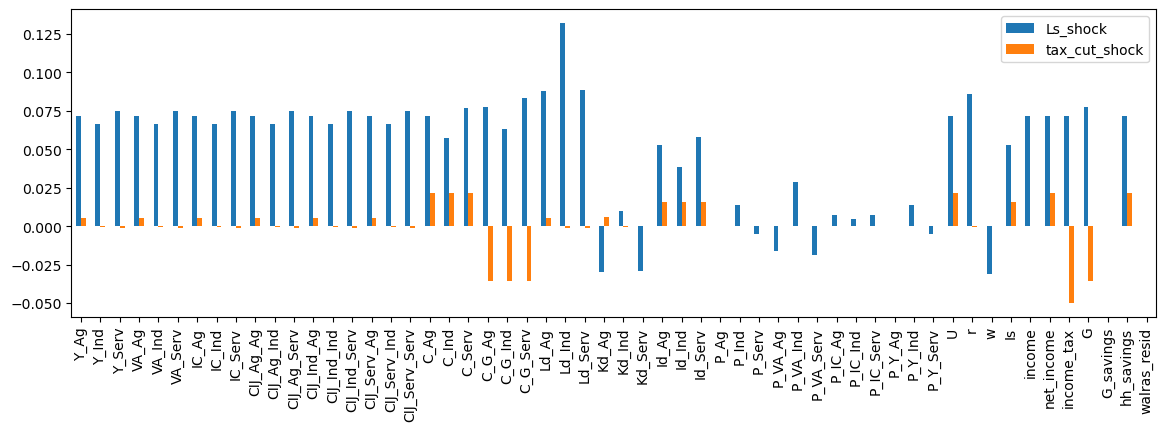

In [161]:
(
    results.assign(
        Ls_shock=lambda x: x.labor_shock / x.initial - 1,
        tax_cut_shock=lambda x: x.tax_cut / x.initial - 1,
    )
    .replace({np.inf: 0})
    .loc[:, ["Ls_shock", "tax_cut_shock"]]
    # .applymap(lambda x: f'{x:0.3%}'))
    .plot.bar(figsize=(14, 4))
)

In [163]:
(
    results.assign(
        Ls_shock=lambda x: x.labor_shock / x.initial - 1,
        tax_cut_shock=lambda x: x.tax_cut / x.initial - 1,
    )
    .replace({np.inf: 0})
    .loc[:, ["Ls_shock", "tax_cut_shock"]]
    .applymap(lambda x: f"{x:0.3%}")
)

,Ls_shock,tax_cut_shock
Y_Ag,7.132%,0.508%
Y_Ind,6.608%,-0.089%
Y_Serv,7.500%,-0.090%
VA_Ag,7.132%,0.508%
VA_Ind,6.608%,-0.089%
VA_Serv,7.500%,-0.090%
IC_Ag,7.132%,0.508%
IC_Ind,6.608%,-0.089%
IC_Serv,7.500%,-0.090%
CIJ_Ag_Ag,7.132%,0.508%
